In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import re
from datetime import datetime

def get_ordered_syllable_for_song(song_syllable_onsets_offsets_ms):
    """Using syllable_onsets_offsets_ms dictionary return an ordered list of tuples (syllable_label, onset, offset)

    syllable_onsets_offsets_ms (dict)
        key: syllable_label
        value: list of tuples (onset time, offset time)

    Alas python dictionaries are not ordered, so we can't rely on the order of the keys.
    """
    raw_syllable_tuples = []
    for syllable_label, times in song_syllable_onsets_offsets_ms.items():
        for start, end in times:
            raw_syllable_tuples.append((syllable_label, start, end))

    sorted_syllable_tuples = sorted(raw_syllable_tuples, key=lambda x: x[1])
    return sorted_syllable_tuples


# Function to extract animal_id and convert date/time to a datetime object using named groups
def get_recording_time_from_filename(recording_file_path_name):
    try:
        # Define the regex pattern with named groups for animal_id, month, day, hour, minute, and second
        pattern = r'(?P<animal_id>[\w\d]+)_\d+\.\d+_(?P<month>\d+)_(?P<day>\d+)_(?P<hour>\d+)_(?P<minute>\d+)_(?P<second>\d+)\.wav$'

        # Search for the pattern in the file path
        match = re.search(pattern, recording_file_path_name)

        if match:
            # Use the named groups to extract the values
            animal_id = match.group('animal_id')
            month = match.group('month').zfill(2)
            day = match.group('day').zfill(2)
            hour = match.group('hour').zfill(2)
            minute = match.group('minute').zfill(2)
            second = match.group('second').zfill(2)

            # Construct a datetime object (assuming the year is 2024 for this example)
            date_time_str = f"2024-{month}-{day} {hour}:{minute}:{second}"
            date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

            return animal_id, date_time_obj
        else:
            return None, None  # Return None if no match is found
    except Exception as e:
        print(f"Error: {e}")
        return None, None

#results[1]['file_name'], get_recording_time_from_filename(results[1]['file_name'])

('USA5288_45355.32438532_3_4_9_0_38.wav',
 ('USA5288', datetime.datetime(2024, 3, 4, 9, 0, 38)))

(None, None)

In [71]:
import csv
import json

file_path = 'Modeling_phys_canary/USA5288_decoded.csv'

def unescape_and_eval(v):
    if v.startswith("''"):
        v = v.replace("''", "")
    if v.startswith("'"):
        v = v.replace("'", "")

    return eval(v)

results = []
with open(file_path, 'r') as f:
    reader = csv.DictReader(f)

    for row in reader:
        syllable_onsets_offsets_timebins = unescape_and_eval(row['syllable_onsets_offsets_timebins'])
        syllable_onsets_offsets_ms = unescape_and_eval(row['syllable_onsets_offsets_ms'])

        ordered_and_timed_syllables = get_ordered_syllable_for_song(syllable_onsets_offsets_ms)
        animal_id, recording_time = get_recording_time_from_filename(row['file_name'])

        data = {
            "file_name": row['file_name'],
            "song_present": row['song_present'],
            #'syllable_onsets_offsets_timebins': syllable_onsets_offsets_timebins,
            #'syllable_onsets_offsets_ms': syllable_onsets_offsets_ms,

            'animal_id': animal_id,
            'recording_time': recording_time,

            'ordered_and_timed_syllables': ordered_and_timed_syllables
        }

        results.append(data)


In [100]:
json_file_path = 'Modeling_phys_canary/USA5288_creation_data.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)

    surgery_treatment_date = datetime.strptime(
        data['treatment_date'], '%Y-%m-%d')

surgery_treatment_date

datetime.datetime(2024, 4, 9, 0, 0)

In [72]:
results[1]

{'file_name': 'USA5288_45355.32438532_3_4_9_0_38.wav',
 'song_present': 'True',
 'animal_id': 'USA5288',
 'recording_time': datetime.datetime(2024, 3, 4, 9, 0, 38),
 'ordered_and_timed_syllables': [('8', 0.0, 1813.3333333333335),
  ('21', 1813.3333333333335, 3348.730158730159),
  ('22', 3348.730158730159, 4425.396825396826),
  ('21', 4425.396825396826, 4611.587301587302),
  ('22', 4611.587301587302, 4619.68253968254),
  ('21', 4619.68253968254, 4622.380952380952),
  ('22', 4622.380952380952, 4625.079365079366),
  ('21', 4625.079365079366, 4630.476190476191),
  ('26', 4630.476190476191, 4751.904761904762),
  ('23', 4751.904761904762, 5010.952380952382),
  ('2', 5010.952380952382, 5785.396825396826),
  ('3', 5785.396825396826, 8041.269841269842),
  ('26', 8041.269841269842, 8068.253968253969),
  ('5', 8068.253968253969, 8618.730158730159),
  ('11', 8618.730158730159, 8929.04761904762),
  ('14', 8929.04761904762, 9028.888888888889)]}

In [104]:
results_pre_surgery = []
results_post_surgery = []

for result in results:
    recording_date = result['recording_time']

    if recording_date < surgery_treatment_date:
        results_pre_surgery.append(result)
    elif recording_date == surgery_treatment_date:
        raise ValueError("Recording date is the same as the surgery date")
    else:
        results_post_surgery.append(result)

len(results_pre_surgery), len(results_post_surgery)

(33374, 18777)

## Histogram of Syllable Length

I want to create a histogram of the average length of each syllable and confidence intervals for all recordings, pre-surgery recordings and post-surgery recordings

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

def get_all_syllables_df_for_results(result_subsets):
    all_song_syllables = []
    for result in result_subsets:
        all_song_syllables.extend(result['ordered_and_timed_syllables'])

    df = pd.DataFrame(all_song_syllables, columns=['syllable_id', 'start_ms', 'end_ms'])
    df['duration'] = df['end_ms'] - df['start_ms']

    df['syllable_id'] = df['syllable_id'].astype(int)

    return df

all_results_df = get_all_syllables_df_for_results(results)
df_pre_surgery = get_all_syllables_df_for_results(results_pre_surgery)
df_post_surgery = get_all_syllables_df_for_results(results_post_surgery)

In [112]:
def plot_syllable_duration_histogram(df, title):
    average_durations = df.groupby('syllable_id')['duration'].mean()

    # Calculate standard error for confidence interval
    sem = df.groupby('syllable_id')['duration'].sem()

    # Define the confidence level (95%)
    confidence_level = 0.95
    degrees_freedom = df.groupby('syllable_id').size() - 1
    confidence_interval = sem * stats.t.ppf((1 + confidence_level) / 2., degrees_freedom)

    # Plot the histogram-like bar plot
    plt.figure(figsize=(10, 6))
    average_durations.plot(kind='bar', yerr=confidence_interval, capsize=5, color='skyblue')

    # Add labels and title
    plt.xlabel('Syllable ID')
    plt.ylabel('Average Duration (ms)')
    plt.title(f'{title} - Average Duration per Syllable ID with 95% Confidence Interval')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show plot
    plt.show()

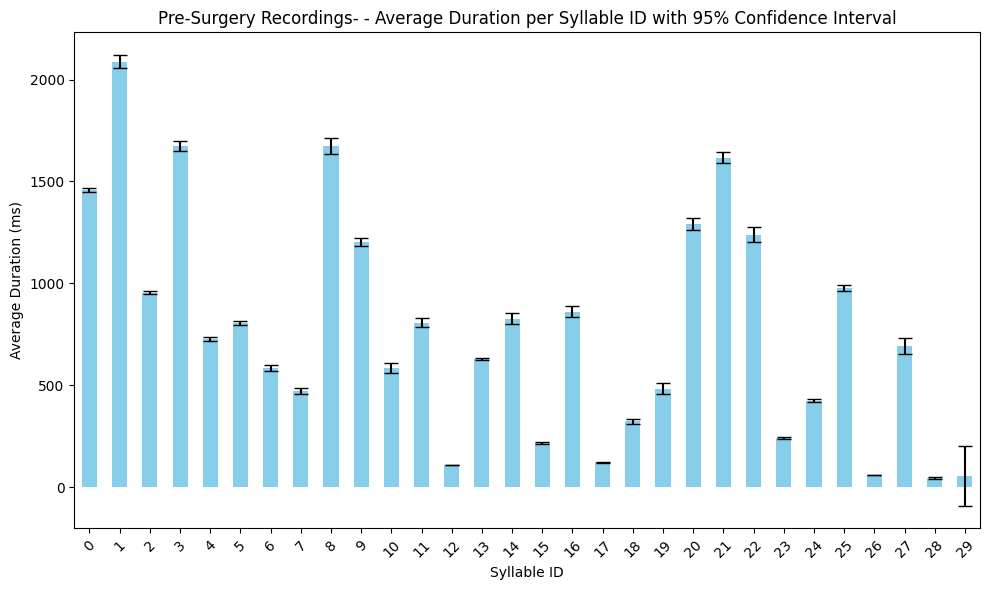

In [113]:
plot_syllable_duration_histogram(df_pre_surgery, 'Pre-Surgery Recordings-')

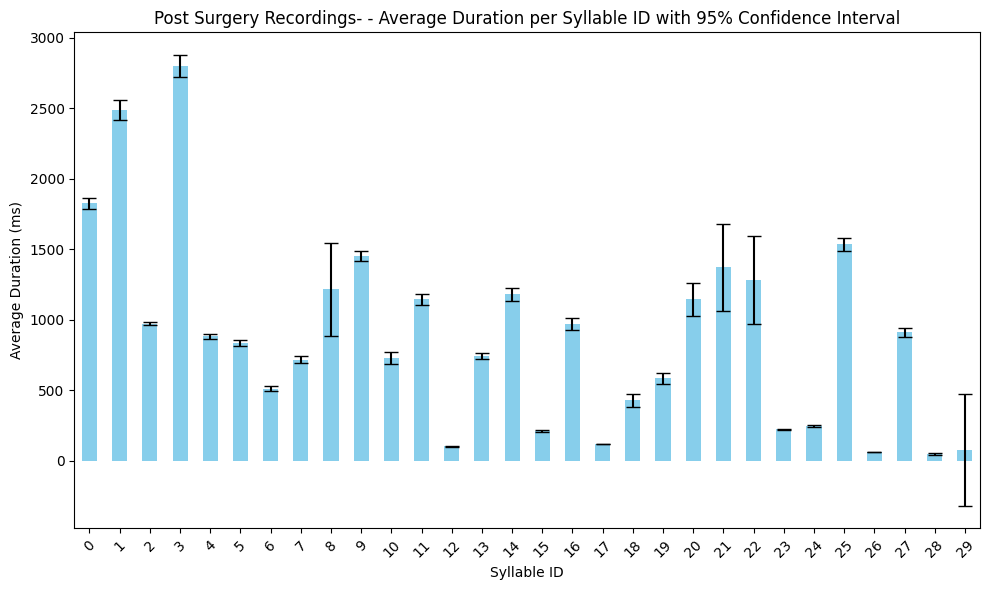

In [114]:
plot_syllable_duration_histogram(df_post_surgery, 'Post Surgery Recordings-')

In [109]:
df_post_surgery

,syllable_id,start_ms,end_ms,duration
0,14,0.000000,1573.174603,1573.174603
1,7,1573.174603,2247.777778,674.603175
2,4,2247.777778,2663.333333,415.555556
3,27,0.000000,1395.079365,1395.079365
4,7,1395.079365,2080.476190,685.396825
...,...,...,...,...
38568,16,3858.730159,4120.476190,261.746032
38569,7,0.000000,48.571429,48.571429
38570,14,0.000000,639.523810,639.523810
38571,7,639.523810,1691.904762,1052.380952
